In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name
from uncertainties import unumpy, ufloat
from sklearn.preprocessing import StandardScaler

In [66]:
CLUSTER_NAME: str = 'NGC 188'

In [67]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
uncert = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_uncert.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
uncert_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp_uncert.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [71]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [72]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [73]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [74]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (122.8367566, 22.37303701)
 (pm_l_cosb, pm_b) in mas / yr
    (-2.32538677, -0.91518539)>

# Plain DBSCAN

In [75]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_best_params.json', 'r') as f:
    best_params = json.load(f)

In [76]:
best_params

{'best_value': 1.0500193666734279,
 'best_params': {'eps': 0.16926266909753007, 'min_samples': 31}}

In [101]:
for _ in range(5):
    normalized_u = normalized + np.random.normal(scale=np.abs(uncert), size=normalized.shape)
    clustered, noise, found, not_found = run_dbscan(normalized_u, gaiadr3, lit_dr3, 0.3, 10, False)

Classified into 88 labels.
Clustered: 816/957
816/957 sources from literature clustered
1335 clustered sources.
Classified into 73 labels.
Clustered: 837/957
837/957 sources from literature clustered
1375 clustered sources.
Classified into 80 labels.
Clustered: 816/957
816/957 sources from literature clustered
1362 clustered sources.
Classified into 82 labels.
Clustered: 831/957
831/957 sources from literature clustered
1373 clustered sources.
Classified into 72 labels.
Clustered: 820/957
820/957 sources from literature clustered
1370 clustered sources.


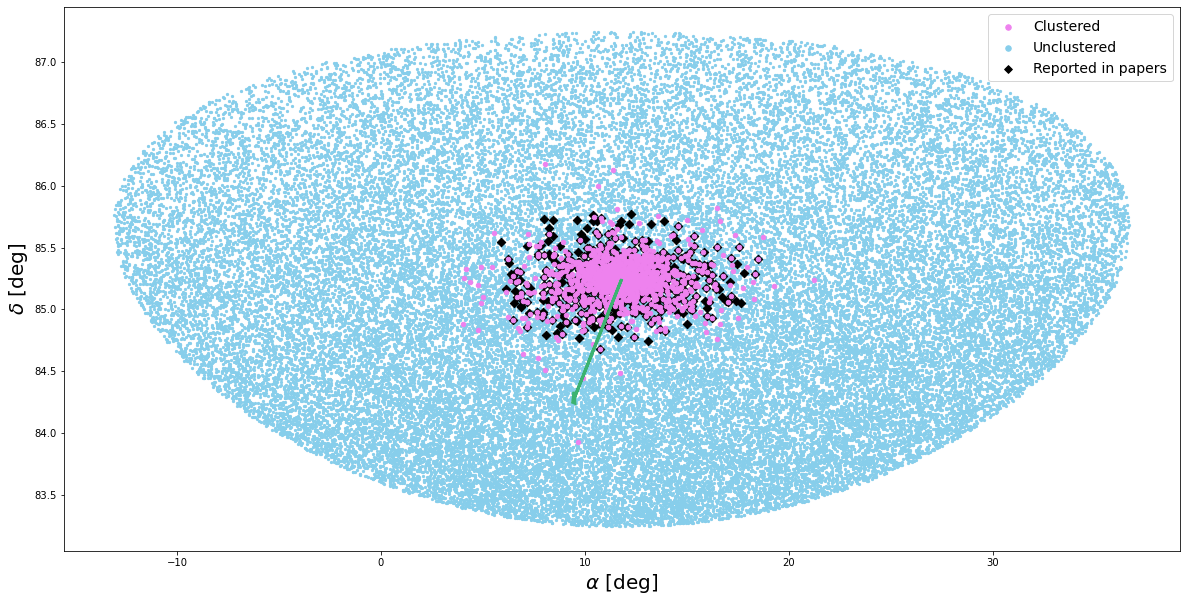

In [102]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

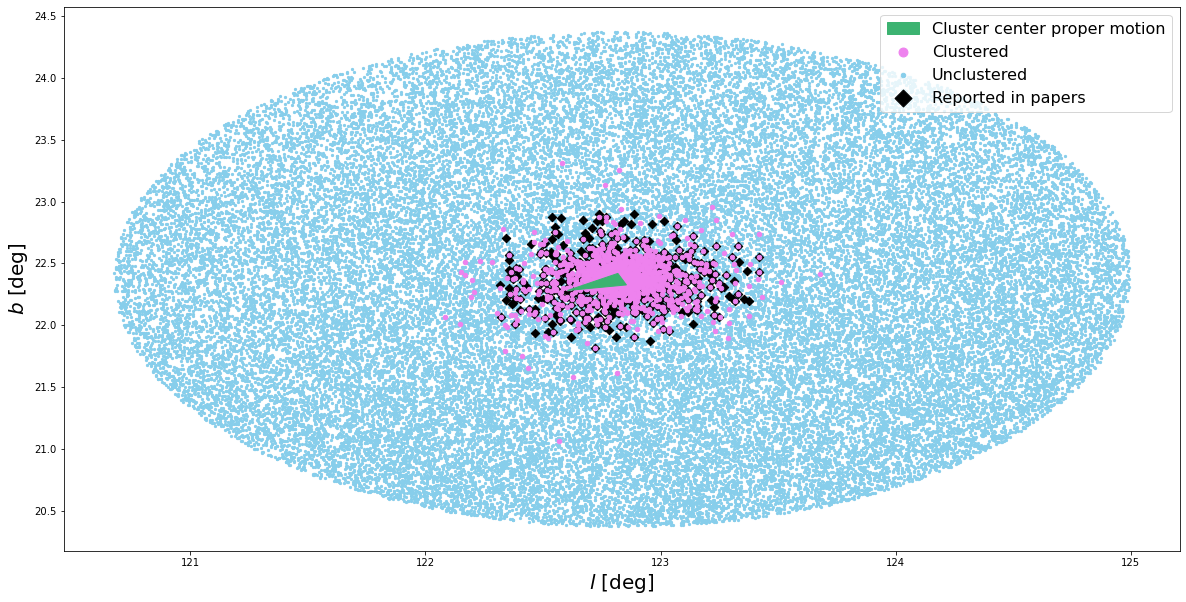

In [103]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.to(u.deg/u.yr).value,
          galactic_coords.pm_b.to(u.deg/u.yr).value,
          linewidth=1.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.25,
          zorder=4,
          label='Cluster center proper motion')
plt.legend(fontsize=16, loc='upper right', markerscale=2.);

In [104]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [105]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

In [106]:
best_params

{'best_value': 0.9663642310523731,
 'best_params': {'eps': 0.0900667918372248, 'min_samples': 42}}

In [122]:
clustered, noise, found, not_found = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.01, 2, False)

Classified into 4386 labels.
Clustered: 707/957
707/957 sources from literature clustered
1285 clustered sources.


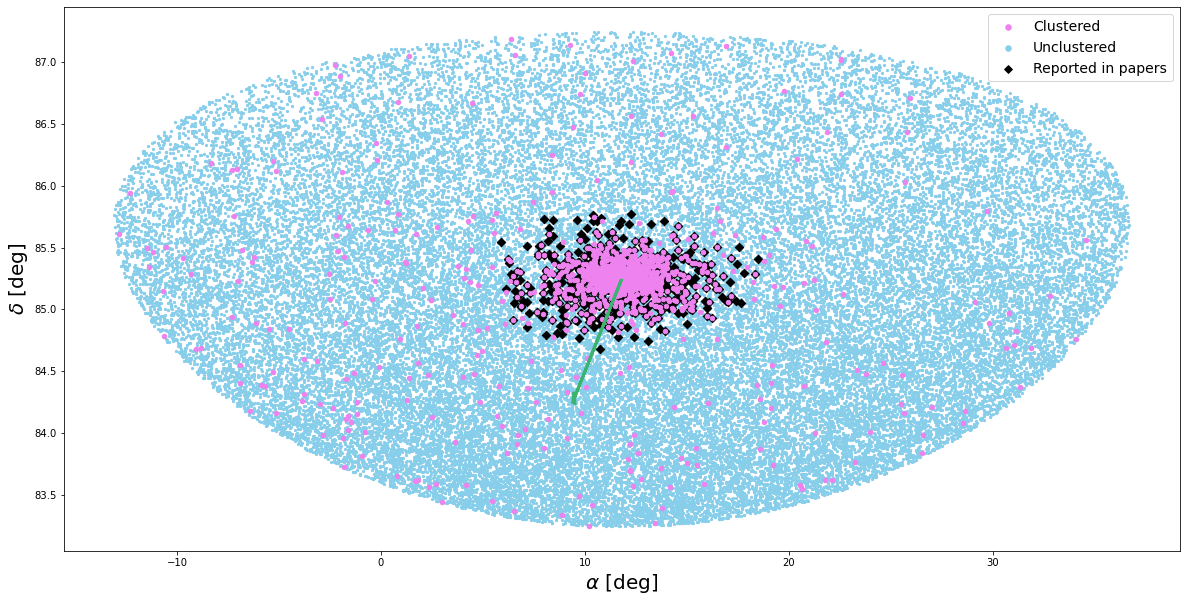

In [123]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

In [ ]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();